In [1]:
from swat import *
import swat as sw
from pprint import pprint
%matplotlib inline
import matplotlib
import sys

sys.path.append('C:\\Users\\weshiz\\Documents\\GitHub\\modify\\python-dlpy')
sys.path.append('C:\\Users\\weshiz\\Documents\\GitHub\\python-fcmp')
from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.images import *
from dlpy.model import *
from python_fcmp.parser import *
from python_fcmp.decorator import *
from python_fcmp import fcmp
from dlpy.lr_scheduler import *
from dlpy.network import *

import numpy
import pandas as pd

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
s = sw.CAS('dlgrd009', 13300)
s.loadactionset('deeplearn')
s.loadactionset('clustering')

NOTE: Added action set 'deeplearn'.
NOTE: Added action set 'clustering'.


[actionset]

 'clustering'

+ Elapsed: 0.00171s, user: 0.000395s, sys: 0.0013s, mem: 0.209mb

In [3]:
# https://go.documentation.sas.com/?docsetId=lesysoptsref&docsetTarget=n16rhscxem9ljwn1kuhn5170xkbg.htm&docsetVersion=9.4&locale=en
s.sessionProp.setSessOpt(caslib='CASUSER', cmplib="CASUSER.fcmpfunction", cmpopt="ALL")

NOTE: 'CASUSER(weshiz)' is now the active caslib.


+ Elapsed: 0.000199s, user: 0.000189s, mem: 0.256mb

### Define forward and backward function

In [4]:
@out_args('y_out')  # pass by reference
@cast_array('srcY', 'weights', 'y_out')  # declare the arguments as array type
def forward_prop(srcHeight, srcWidth, srcDepth, srcY, weights, y_out):
    mean = numpy.zeros((6)) # initialize mean and var with length
    var = numpy.zeros((6))
    
    wd = fcmp.reduce_axis((0, srcWidth)) # create an iterator which iterate from 0 to srcWidth
    ht = fcmp.reduce_axis((0, srcHeight))
    eps = 0.0001 # avoid deviding by 0
    srcY = fcmp.reshape(srcY, (srcDepth, srcHeight, srcWidth)) # reshape the array and access each element via multiple subscripts
    mean = fcmp.compute((srcDepth), lambda i: fcmp.sum(srcY[i, ht, wd] / srcHeight / srcWidth, [ht, wd])) # generate a new variable and describle the computation rule
    var = fcmp.compute((srcDepth), lambda i: fcmp.sum((srcY[i, ht, wd] - mean[i]) ** 2 / srcHeight / srcWidth, [ht, wd]))
    y_out = fcmp.compute((srcDepth, srcHeight, srcWidth), lambda i, j, m: (srcY[i, j, m] - mean[i]) / (var[i] + eps) ** 0.5)
    
    return

@out_args('gradient_out', 'srcDeltas_out')
@cast_array('srcY', 'Y', 'weights', 'deltas', 'gradient_out', 'srcDeltas_out')
def back_prop(srcHeight, srcWidth, srcDepth, srcY, Y, weights, deltas, gradient_out, srcDeltas_out):
    dmean = numpy.zeros((6))
    dvar = numpy.zeros((6))
    mean = numpy.zeros((6))
    var = numpy.zeros((6))
    grad_sigma = numpy.zeros((6))
    grad_mean = numpy.zeros((6))
    grad_mean_2 = numpy.zeros((6))
    for i in range(srcHeight*srcWidth*srcDepth):
        srcDeltas_out[i] = 0
    
    by_norm = 1 / (srcHeight * srcWidth)
    
    wd = fcmp.reduce_axis((0, srcWidth))
    ht = fcmp.reduce_axis((0, srcHeight))
    
    srcY = fcmp.reshape(srcY, (srcDepth, srcHeight, srcWidth))
    deltas = fcmp.reshape(deltas, (srcDepth, srcHeight, srcWidth))
    
    eps = 0.0001
    
    mean = fcmp.compute((srcDepth), lambda i: fcmp.sum(srcY[i, ht, wd] / srcHeight / srcWidth, [ht, wd]))
    var = fcmp.compute((srcDepth), lambda i: fcmp.sum((srcY[i, ht, wd] - mean[i]) ** 2 / srcHeight / srcWidth, [ht, wd]))
    
    grad_sigma = fcmp.compute((srcDepth), lambda i: fcmp.sum(deltas[i, ht, wd] * (srcY[i] - mean[i]), [ht, wd]))
    grad_sigma = fcmp.compute((srcDepth), lambda i: grad_sigma[i] * (-0.5) * (var[i] + eps) ** -1.5)
    
    grad_mean = fcmp.compute((srcDepth), lambda i: fcmp.sum(deltas[i, ht, wd] * (-1 * (var[i] + eps) ** 0.5), [ht, wd]))
    grad_mean_2 = fcmp.compute((srcDepth), lambda i: fcmp.sum(srcY[i, ht, wd] - mean[i], [ht, wd]))
    grad_mean = fcmp.compute((srcDepth), lambda i: grad_mean[i] + grad_sigma[i] * by_norm * 2 * grad_mean_2[i] * -1)
    
    srcDeltas_out = fcmp.compute((srcDepth), lambda i: fcmp.sum(srcY[i, ht, wd] - mean[i], [ht, wd]))
    srcDeltas_out = fcmp.compute((srcDepth), lambda i: deltas[i] * (1 / (var[i] + eps)** 0.5) + grad_sigma[i] * by_norm * 2 + srcDeltas_out[i] + grad_mean[i] * by_norm)
    
    return

def dummy_loss(t, target):
    return t

Arguments, srcY, weights, y_out, are casted to array type
Arguments, y_out, are declared as outargs.
Arguments, srcY, Y, weights, deltas, gradient_out, srcDeltas_out, are casted to array type
Arguments, gradient_out, srcDeltas_out, are declared as outargs.


### Generate forward FCMP code

In [5]:
forward_fcmp_code = python_to_fcmp(func=forward_prop, print=True)

('function forward_prop(srcHeight, srcWidth, srcDepth, srcY[*], weights[*], y_out[*]);outargs y_out;\n'
 '    array mean[6]; do i = 1 to 6 by 1; mean[i] = 0; end;\n'
 '    array var[6]; do i = 1 to 6 by 1; var[i] = 0; end;\n'
 '    eps = 0.0001;\n'
 '    do i = 0 to (srcDepth - 1) by 1;\n'
 '        do ht = 0 to (srcHeight - 1) by 1;\n'
 '            do wd = 0 to (srcWidth - 1) by 1;\n'
 '                mean[i + 1] = (mean[i + 1] + ((srcY[(((srcHeight * srcWidth) * i) + (srcWidth * ht)) + wd + 1] / srcHeight) / srcWidth));\n'
 '            end;\n'
 '        end;\n'
 '    end;\n'
 '\n'
 '    do i = 0 to (srcDepth - 1) by 1;\n'
 '        do ht = 0 to (srcHeight - 1) by 1;\n'
 '            do wd = 0 to (srcWidth - 1) by 1;\n'
 '                var[i + 1] = (var[i + 1] + (((srcY[(((srcHeight * srcWidth) * i) + (srcWidth * ht)) + wd + 1] - mean[i + 1]) ** 2 / srcHeight) / srcWidth));\n'
 '            end;\n'
 '        end;\n'
 '    end;\n'
 '\n'
 '    do i = 0 to (srcDepth - 1) by 1;\n'
 '

### Generate backward FCMP code

In [6]:
backward_fcmp_code = python_to_fcmp(func=back_prop, print=True)

('function back_prop(srcHeight, srcWidth, srcDepth, srcY[*], Y[*], weights[*], deltas[*], gradient_out[*], srcDeltas_out[*]);outargs gradient_out, srcDeltas_out;\n'
 '    array dmean[6]; do i = 1 to 6 by 1; dmean[i] = 0; end;\n'
 '    array dvar[6]; do i = 1 to 6 by 1; dvar[i] = 0; end;\n'
 '    array mean[6]; do i = 1 to 6 by 1; mean[i] = 0; end;\n'
 '    array var[6]; do i = 1 to 6 by 1; var[i] = 0; end;\n'
 '    array grad_sigma[6]; do i = 1 to 6 by 1; grad_sigma[i] = 0; end;\n'
 '    array grad_mean[6]; do i = 1 to 6 by 1; grad_mean[i] = 0; end;\n'
 '    array grad_mean_2[6]; do i = 1 to 6 by 1; grad_mean_2[i] = 0; end;\n'
 '    do i = 0 to ((srcHeight * srcWidth) * srcDepth) - 1 by 1;\n'
 '        srcDeltas_out[i + 1] = 0;\n'
 '    end;\n'
 '    by_norm = (1 / (srcHeight * srcWidth));\n'
 '    eps = 0.0001;\n'
 '    do i = 0 to (srcDepth - 1) by 1;\n'
 '        do ht = 0 to (srcHeight - 1) by 1;\n'
 '            do wd = 0 to (srcWidth - 1) by 1;\n'
 '                mean[i + 1] = 

### Register the functions

In [7]:
# register forward and backward function together
register_fcmp_routines(s,
                       routine_code= forward_fcmp_code + backward_fcmp_code,
                       function_tbl_name='fcmpfunction')

NOTE: Cloud Analytic Services saved the file FCMPFUNCTION.sashdat in caslib CASUSER(weshiz).


### Loading training data
In the case, we have Fashion MNIST data

In [8]:
test = ImageTable.load_files(conn=s, path='/cas/DeepLearn/weshiz/fashion-mnist/testing')

In [9]:
test.columninfo()

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,_image_,,1,varbinary(image),837,837,,0,0
1,_label_,,2,varchar,1,1,,0,0
2,_filename_0,,3,varchar,8,8,,0,0
3,_id_,,4,int64,8,12,,0,0


### Build a model

In [10]:
model = Sequential(conn=s, model_table='lenet5')

model.add(InputLayer(n_channels=1, width=28, height=28, scale=1.0/255, offsets=None,
                     random_flip=None, random_crop=None))

model.add(Conv2d(n_filters=6, width=3, height=3, stride=1))

# instance normalizationi
model.add(FCMPLayer(width=28, height=28, depth=6, n_weights=0, 
                    forward_func='forward_prop', backward_func='back_prop',
                    name='FCMPLayer1'))

model.add(Pooling(width=2, height=2, stride=2, pool='max'))

model.add(Conv2d(n_filters=16, width=5, height=5, stride=1))
model.add(Pooling(width=2, height=2, stride=2, pool='max'))

model.add(Dense(n=120))
model.add(Dense(n=84))

model.add(OutputLayer(n=10))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: FCMP layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


### Train

In [12]:
solver = VanillaSolver(clip_grad_max=100, clip_grad_min=-100, learning_rate=0.001,
                       learning_rate_policy='step', gamma=0.1, step_size=30)
optimizer = Optimizer(algorithm=solver, seed=13309, max_epochs=15, log_level=3, mini_batch_size=32, reg_l2=0.0001)

In [13]:
model.fit(data=test, optimizer=optimizer, n_threads=8, target='_label_', inputs='_image_', nominals='_label_')

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 107690.
NOTE:  The approximate memory cost is 43.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.04 (s).
NOTE:  The total number of threads on each worker is 8.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 256.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:     10
NOTE:  Levels for the target variable:
NOTE:  Level      0: 0
NOTE:  Level      1: 1
NOTE:  Level      2: 2
NOTE:  Level      3: 3
NOTE:  Level      4: 4
NOTE:  Level      5: 5
NOTE:  Level      6: 6
NOTE:  Level      7: 7
NOTE:  Level      8: 8
NOTE:  Level      9: 9
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Number of FCMP layers in model: 1
NOTE:  FCMP layer 'fcmplayer1' has input tenso

NOTE:     19   256    0.001             1.86     0.5547    0.02386     0.06
NOTE:     20   256    0.001            1.826      0.582    0.02386     0.06
NOTE:     21   256    0.001             1.84     0.5352    0.02386     0.06
NOTE:     22   256    0.001            1.842     0.5859    0.02387     0.06
NOTE:     23   256    0.001            1.872     0.6133    0.02387     0.06
NOTE:     24   256    0.001            1.805     0.5078    0.02387     0.06
NOTE:     25   256    0.001            1.766      0.543    0.02387     0.06
NOTE:     26   256    0.001            1.764     0.4961    0.02387     0.06
NOTE:     27   256    0.001            1.844     0.5664    0.02387     0.06
NOTE:     28   256    0.001             1.77     0.5234    0.02387     0.06
NOTE:     29   256    0.001            1.741     0.5156    0.02387     0.06
NOTE:     30   256    0.001            1.784     0.5117    0.02387     0.06
NOTE:     31   256    0.001            1.814     0.5195    0.02387     0.06
NOTE:     32

NOTE:      7   256    0.001            1.445      0.418     0.0239     0.06
NOTE:      8   256    0.001             1.44     0.3867     0.0239     0.06
NOTE:      9   256    0.001            1.446      0.418     0.0239     0.06
NOTE:     10   256    0.001            1.381     0.3477     0.0239     0.06
NOTE:     11   256    0.001            1.471     0.4336     0.0239     0.06
NOTE:     12   256    0.001            1.387     0.3438     0.0239     0.06
NOTE:     13   256    0.001            1.441     0.3984    0.02391     0.06
NOTE:     14   256    0.001            1.367     0.3711    0.02391     0.06
NOTE:     15   256    0.001            1.464     0.4609    0.02391     0.06
NOTE:     16   256    0.001            1.367      0.375    0.02391     0.06
NOTE:     17   256    0.001             1.39     0.3555    0.02391     0.06
NOTE:     18   256    0.001            1.356     0.3477    0.02391     0.06
NOTE:     19   256    0.001            1.381     0.3516    0.02391     0.06
NOTE:     20

NOTE:      2   256    0.001            1.122     0.3008    0.02395     0.06
NOTE:      3   256    0.001            1.108     0.2734    0.02395     0.06
NOTE:      4   256    0.001            1.055     0.2852    0.02395     0.06
NOTE:      5   256    0.001            1.135     0.3125    0.02395     0.06
NOTE:      6   256    0.001            1.116     0.3086    0.02395     0.06
NOTE:      7   256    0.001            1.021     0.2461    0.02395     0.06
NOTE:      8   256    0.001            1.098     0.3125    0.02395     0.06
NOTE:      9   256    0.001            1.068     0.2773    0.02395     0.06
NOTE:     10   256    0.001            1.096     0.2852    0.02395     0.06
NOTE:     11   256    0.001            1.147     0.3047    0.02395     0.06
NOTE:     12   256    0.001            1.204     0.3672    0.02396     0.06
NOTE:     13   256    0.001            1.117     0.2773    0.02396     0.06
NOTE:     14   256    0.001            1.083     0.3203    0.02396     0.06
NOTE:     15

NOTE:     29   256    0.001           0.9941      0.293    0.02399     0.06
NOTE:     30   256    0.001           0.9265       0.25    0.02399     0.06
NOTE:     31   256    0.001           0.8923     0.2305    0.02399     0.06
NOTE:     32   256    0.001           0.9498     0.2734    0.02399     0.06
NOTE:     33   256    0.001           0.9138     0.2617    0.02399     0.06
NOTE:     34   256    0.001           0.9702     0.2891    0.02399     0.06
NOTE:     35   256    0.001           0.9277     0.2656    0.02399     0.06
NOTE:     36   256    0.001           0.8739     0.2188      0.024     0.06
NOTE:     37   256    0.001           0.9244     0.2656      0.024     0.06
NOTE:     38   256    0.001           0.9585     0.2695      0.024     0.06
NOTE:     39   256    0.001           0.9105     0.2461      0.024     0.06
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  10        0.001          0.9648     0.2709     2.41
NOTE:  Batch nUsed Learning Rate        Loss 

NOTE:     30   256    0.001           0.8263     0.2617    0.02403     0.06
NOTE:     31   256    0.001           0.8105     0.2227    0.02403     0.06
NOTE:     32   256    0.001           0.8678     0.2656    0.02403     0.06
NOTE:     33   256    0.001           0.7547     0.2031    0.02403     0.06
NOTE:     34   256    0.001           0.8463     0.2578    0.02403     0.06
NOTE:     35   256    0.001           0.8351     0.2656    0.02403     0.06
NOTE:     36   256    0.001           0.7539     0.2188    0.02404     0.06
NOTE:     37   256    0.001           0.7923     0.2266    0.02404     0.06
NOTE:     38   256    0.001           0.8568     0.2617    0.02404     0.06
NOTE:     39   256    0.001           0.8144     0.2813    0.02404     0.06
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  13        0.001          0.8443     0.2529     2.41
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   256    0.001      

,Descr,Value
0,Model Name,lenet5
1,Model Type,Convolutional Neural Network
2,Number of Layers,9
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,2
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,2
8,Number of FCMP Layers,1
9,Number of Weight Parameters,107454


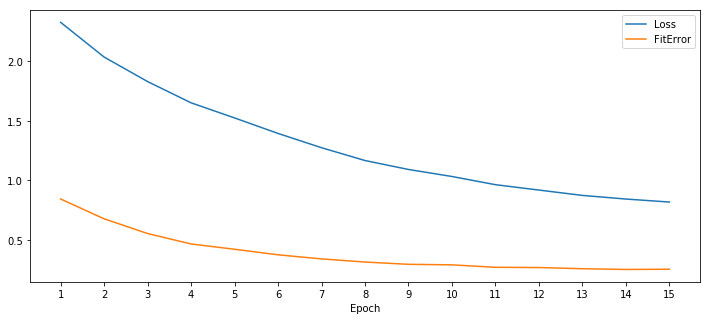

In [14]:
model.plot_training_history()

In [ ]:
s.endsession()